In [2]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import corner
from tqdm import tqdm_notebook

# Set plot params
plt.rc('font', size=14)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=14)    # legend fontsize

# H2b - Variational method with Metropolis

## Task 1

The energy is given as

$$ E_L = -4 + \frac{(\hat{r_1}-\hat{r_2}) \cdot (r_1 - r_2) }{r_{12}(1+\alpha r_{12})^2} - \frac{1}{r_{12}(1 + \alpha r_{12})^3} - \frac{1}{4(1+\alpha r_{12})^4} + \frac{1}{r_{12}},$$

where

$$ (\hat{r_1}-\hat{r_2}) \cdot (r_1 - r_2) = \Delta \hat{r}\cdot (x_1-x_2, y_1-y_2, z_1-z_2) = \Delta \hat{r} \cdot (\Delta x, \Delta y, \Delta z) = $$

$$ = \Delta x + \Delta y + \Delta z $$

$\Delta \hat{x}$ denotes a unit vector in the direction of $\Delta x$.

To find the density $\rho(r)$ we need to determine $r$. How do we do this for our system where we have two particles with different position vectors.

(100000, 2)


Text(0, 0.5, 'Trace')

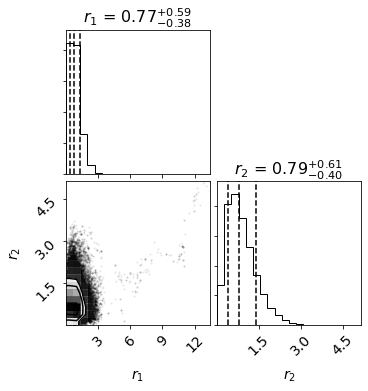

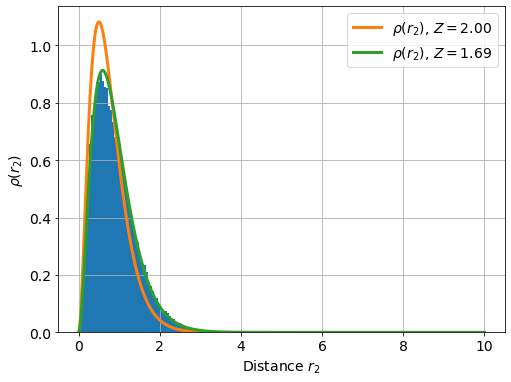

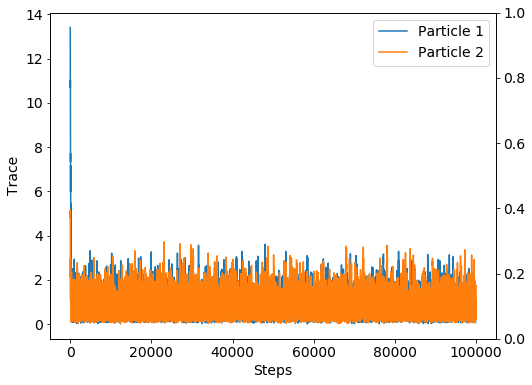

In [18]:
# Load rho data - and compare to central field approximation
def centralField(r, Z):
    return Z**3 * 4*r**2 * np.exp(-2*Z*r)

data = np.loadtxt('task1and2/rho.dat')
r2 = data[:,1]

Zs = [2, 27/16]

r = np.linspace(0,10, 500)

r_samples = np.vstack([data[:,0], data[:,1]]).T
print(r_samples.shape)

# Corner plot

figure = corner.corner(r_samples, labels=[r"$r_1$", r"$r_2$"],
                       quantiles=[0.16, 0.5, 0.84],
                       show_titles=True, title_kwargs={"fontsize": 16})

# plot 
fig, ax = plt.subplots(figsize=(8,6))
ax.hist(r2,100, density=True)
for Z in Zs:
    ax.plot(r, centralField(r, Z), linewidth=3, label=fr'$\rho(r_2)$, $Z=${Z:.2f}')
ax.legend(loc='best')
ax.grid()
ax.set_xlabel(r'Distance $r_2$')
ax.set_ylabel(r'$\rho(r_2)$')

# Plot trace
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(data[:,0], label='Particle 1')
ax.plot(data[:,1], label='Particle 2')
ax_twin = ax.twinx()
ax.legend(loc='best')
ax.set_xlabel("Steps")
ax.set_ylabel("Trace")

Text(0.5, 0, '$x = \\cos{\\theta}}$')

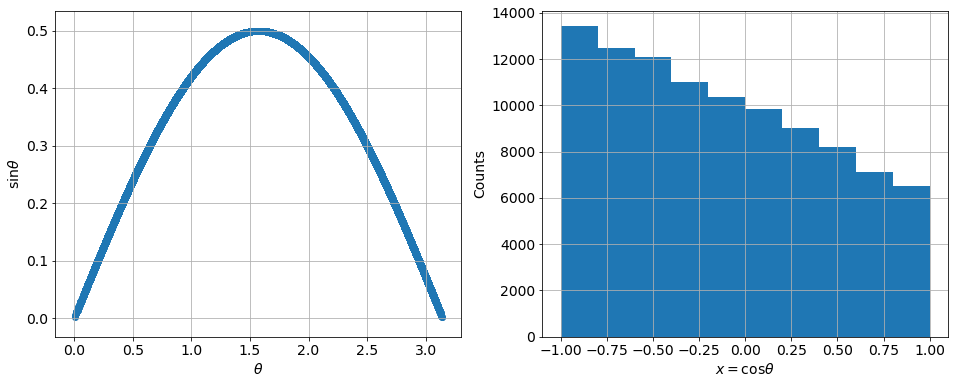

In [19]:
# Plot theta data

# Load rho data 
data = np.loadtxt('task1and2/theta.dat')

# plot 
fig, ax = plt.subplots(1,2,figsize=(16,6))

ax[0].scatter(data[:,0], data[:,1])
ax[0].grid()
ax[0].set_ylabel(r'$\sin{\theta}$')
ax[0].set_xlabel(r'$\theta$')


ax[1].hist(np.cos(data[:,0]))
ax[1].grid()
ax[1].set_ylabel(r'Counts')
ax[1].set_xlabel(r'$x = \cos{\theta}}$')

We see a higher sampled region for $\cos{\theta} \approx -1$ than for 1. This could be due to the walk starting out in this region, and thus taking more steps there. Since $p(\theta)$ should be uniform, the choice of starting points makes a difference now that we don't have any warm up steps.

Average energy is: -2.8823 a.u.


(-10, 0)

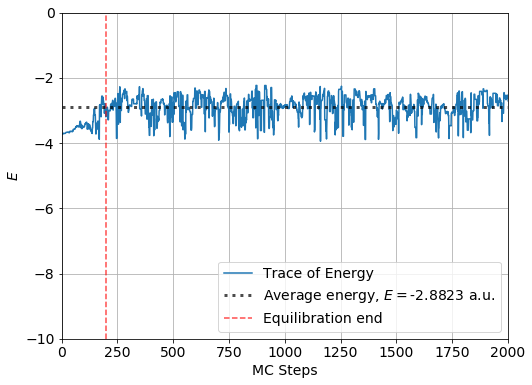

In [22]:
# Plot energy data 

# Load rho data 
data = np.loadtxt('task1and2/energy.dat')
avg_E = np.mean(data)
print(f'Average energy is: {avg_E:.4f} a.u.')

# plot 
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(data, label='Trace of Energy')
ax.axhline(avg_E, linewidth=3, color='k', linestyle=':', alpha=0.7, label=fr'Average energy, $E=${avg_E:.4f} a.u.')
ax.axvline(200, color='r', linestyle='--', alpha=0.7, label=fr'Equilibration end')
ax.grid()
ax.set_ylabel(r'$E$')
ax.set_xlabel(r'MC Steps')
ax.legend(loc='best')
ax.set_xlim(0,2000)
ax.set_ylim(-10,0)

# Task 2 - equilibration and statistical inneficiency

# Task 3 - Minimum value of E

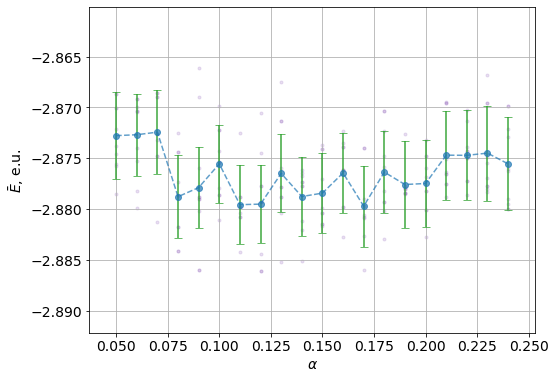

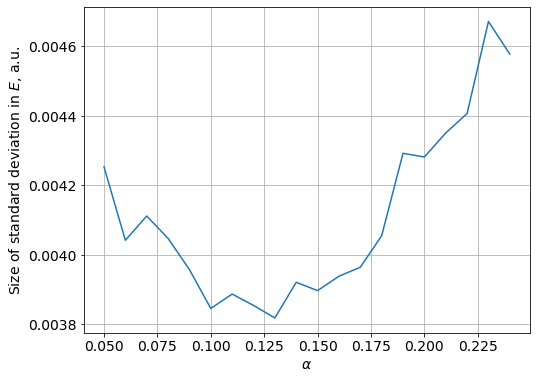

In [60]:
# Load energy and statistical inefficiency data
data = np.loadtxt('task3.dat')

# Calculate error bars - using statistical inefficiency, varE and N
varE = data[:,4]*data[:,2]/data[:,3]  # Usage of 

# Use multiple values for each alpha to minimize error
alphas = []
E = []
errE = []

for alpha in np.unique(data[:,0]):
    idx = np.where(data[:,0]==alpha)
    average_meanE = np.sum(data[idx,1])/len(idx[0]) # Mean of mean energies
    average_varE = np.sum(varE[idx])/len(idx[0]) # Mean of variance in energies ???????
    alphas.append(alpha)
    E.append(average_meanE)
    errE.append(np.sqrt(average_varE))

fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(data[:,0], data[:,1], color='C4', marker='.', alpha=0.2)
ax.errorbar(alphas, E, yerr=errE, elinewidth=2, ecolor='C2', alpha=0.7, capsize=4, fmt='C0o--')
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$\bar{E}$, e.u.')
ax.grid()

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(alphas, errE)
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'Size of standard deviation in $E$, a.u.')
ax.grid()


# Task 4

We will use a damped steepest descent method to optimize $\alpha$:

$$ \alpha_{p+1} = \alpha_p - \gamma_p \nabla_\alpha E(\alpha)$$
where $E(\alpha)$ is the metropolis sampled average energy for a fix $\alpha$. We approximate the gradient by:

$$\nabla_\alpha E(\alpha) = 2[\left<E_L(R) \nabla_\alpha \ln{\Psi_T(R)}\right> - \left<E_L(R)\right> \left<\nabla_\alpha \ln{\Psi_T(R)}\right>]$$

$E_L(R)$ is the energy as a fuction of sampled positions, and $\Psi_T(R)$ is the trial wavefunction. The averages are taken over the path of configuration spaces, i.e. the over the sampled points during the metropolis algorithm. Thus, in order to change $\alpha$ we need to run one whole metropolis sampling of the function, so the method is fairly expensive.

The constant $\gamma_p$ is given as: 

$$ \gamma_p = Ae^{-\beta} = [A=1] = e^{-\beta}. $$

Finally, we need the gradient (derivative) of the log of the trial wavefunction with respect to $\alpha$.

$$ \Psi_T(R) = e^{-2r_1}e^{-2r_2}e^{\frac{r_{12}}{2(1+\alpha r_{12})}} \rightarrow $$

$$ \ln{\Psi_T(R)} = -2r_1 - 2 r_2 + \frac{r_{12}}{2(1+\alpha r_{12})} \rightarrow $$

$$ \nabla_\alpha \ln{\Psi_T(R)} = -\frac{r_{12}^2}{2(1+\alpha r_{12})^2} $$


Text(0, 0.5, '$\\alpha$')

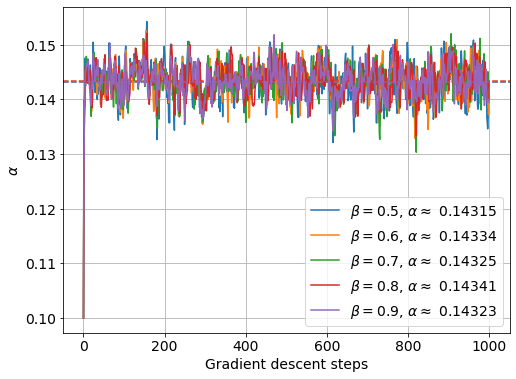

In [54]:
data = np.loadtxt('task4.dat')

fig, ax = plt.subplots(figsize=(8,6))
betas = data[0,:]

for idx, beta in enumerate(betas):
    # Don't plot the beta - first element
    halflength = (int)((len(data)-2)/2 + 2)
    meanE = np.mean(data[halflength:,idx])
    ax.plot(data[1:,idx], color=f'C{idx}', label=fr'$\beta=${beta}, $\alpha \approx $ {meanE:.5f}')  
    ax.axhline(meanE, color=f'C{idx}', linestyle='--', alpha=0.7)
    
ax.grid()
ax.legend(loc='lower right')
ax.set_xlabel('Gradient descent steps')
ax.set_ylabel(r'$\alpha$')

# Task 5

In [59]:
# Load data
data = np.loadtxt("task5.dat")

# Calculate variance of E by correcting with the statistical inneficiency
varE = data[:,4] * data[:,2] / data[:,3]

# Take average of mean energies and variances
meanE = np.mean(data[:,1])
errE = np.sqrt(np.mean(varE))

print(fr'Carefully calculated value is $ E_0 \approx $ {meanE:.3f}$\pm${errE:.4f} a.u.')

Carefully calculated value is $ E_0 \approx $ -2.878$\pm$0.0039 a.u.
